# NYC Taxi Project

# Data Gathering & Preparation

### Load 2016 NYC Taxi data from BigQuery

In [9]:
from google.cloud import bigquery
from datetime import datetime, date
from pyproj import Proj, transform

from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score
from sklearn import preprocessing
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import sklearn
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
import os
import warnings
import time
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/yuhang/Desktop/My First Project-383e17ae8e1a.json"

#### Here we compute the time bewteen pickup and dropoff and generate our response variable `travel_time`. We then join the taxi data with the publicly available 2016 weather data.

In [193]:
client = bigquery.Client()
query = (
    """
    SELECT * FROM 
    (
    SELECT pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,\
    passenger_count,trip_distance,pickup_datetime,\
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` 
    ) a 
    INNER JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,\
     fog,rain_drizzle,snow_ice_pellets,thunder,\
     temp as temperature, visib as visibility, \
     IF (wdsp="999.9", 0, CAST(wdsp AS Float64)) as wind_speed,\
     gust as wind_gust, prcp as precipitation, IF (sndp=999.9, 0, sndp) as snow_depth
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725030'
    ) b
    on CAST(a.date_of_year AS STRING) = b.date_of_year2
    where a.month_of_year < 13 and a.trip_distance < 100 and\
    a.pickup_longitude <> 0 and a.pickup_latitude <> 0 and \
    a.dropoff_longitude <> 0 and a.dropoff_latitude <> 0 and \
    a.travel_time < 6000 and a.travel_time > 60\
    and b.temperature <> 999.9 and b.visibility <> 999 \
    and b.wind_gust <> 999.9 and b.precipitation <> 99.99
    ORDER BY RAND()
    LIMIT 3000000
    """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,pickup_datetime,travel_time,date_of_year,month_of_year,date_of_year2,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth
0,-73.987106,40.729305,-73.988228,40.723179,5,0.79,2016-03-05 00:16:28+00:00,809,2016-03-05,3,2016-03-05,0,0,0,0,34.8,10.0,9.4,19.0,0.04,1.2
1,-73.988998,40.738209,-73.960381,40.774647,1,3.72,2016-02-02 23:22:43+00:00,959,2016-02-02,2,2016-02-02,0,0,0,0,45.5,10.0,5.0,17.1,0.00,1.2
2,-74.003967,40.742897,-73.935898,40.755882,2,5.60,2016-03-11 04:35:09+00:00,1153,2016-03-11,3,2016-03-11,0,1,0,0,61.2,9.8,9.7,28.0,0.04,0.0
3,-73.975220,40.748051,-73.972908,40.746620,5,1.20,2016-01-18 20:48:00+00:00,530,2016-01-18,1,2016-01-18,0,0,1,0,29.0,9.2,15.0,31.1,0.05,0.0
4,-73.962250,40.779129,-73.937210,40.855160,3,6.88,2016-01-12 17:15:06+00:00,2127,2016-01-12,1,2016-01-12,0,1,0,0,32.9,10.0,9.0,28.0,0.00,0.0


#### Extend feature 'weekday' and 'hour'

In [194]:
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour)

#### Drop off some features

In [195]:
Drop = ['date_of_year','date_of_year2','pickup_datetime']
df.drop(Drop,axis='columns',inplace=True)

#### Remove missing values

In [196]:
# Remove missing values
print('Original data size: ',len(df))
df = df.dropna()
print('After filter with NaN:', len(df))

Original data size:  3000000
After filter with NaN: 3000000


## Visualize the features of each value
In order to analyse features, I first visualize all features and oberserve the abnormal values of each feature. 

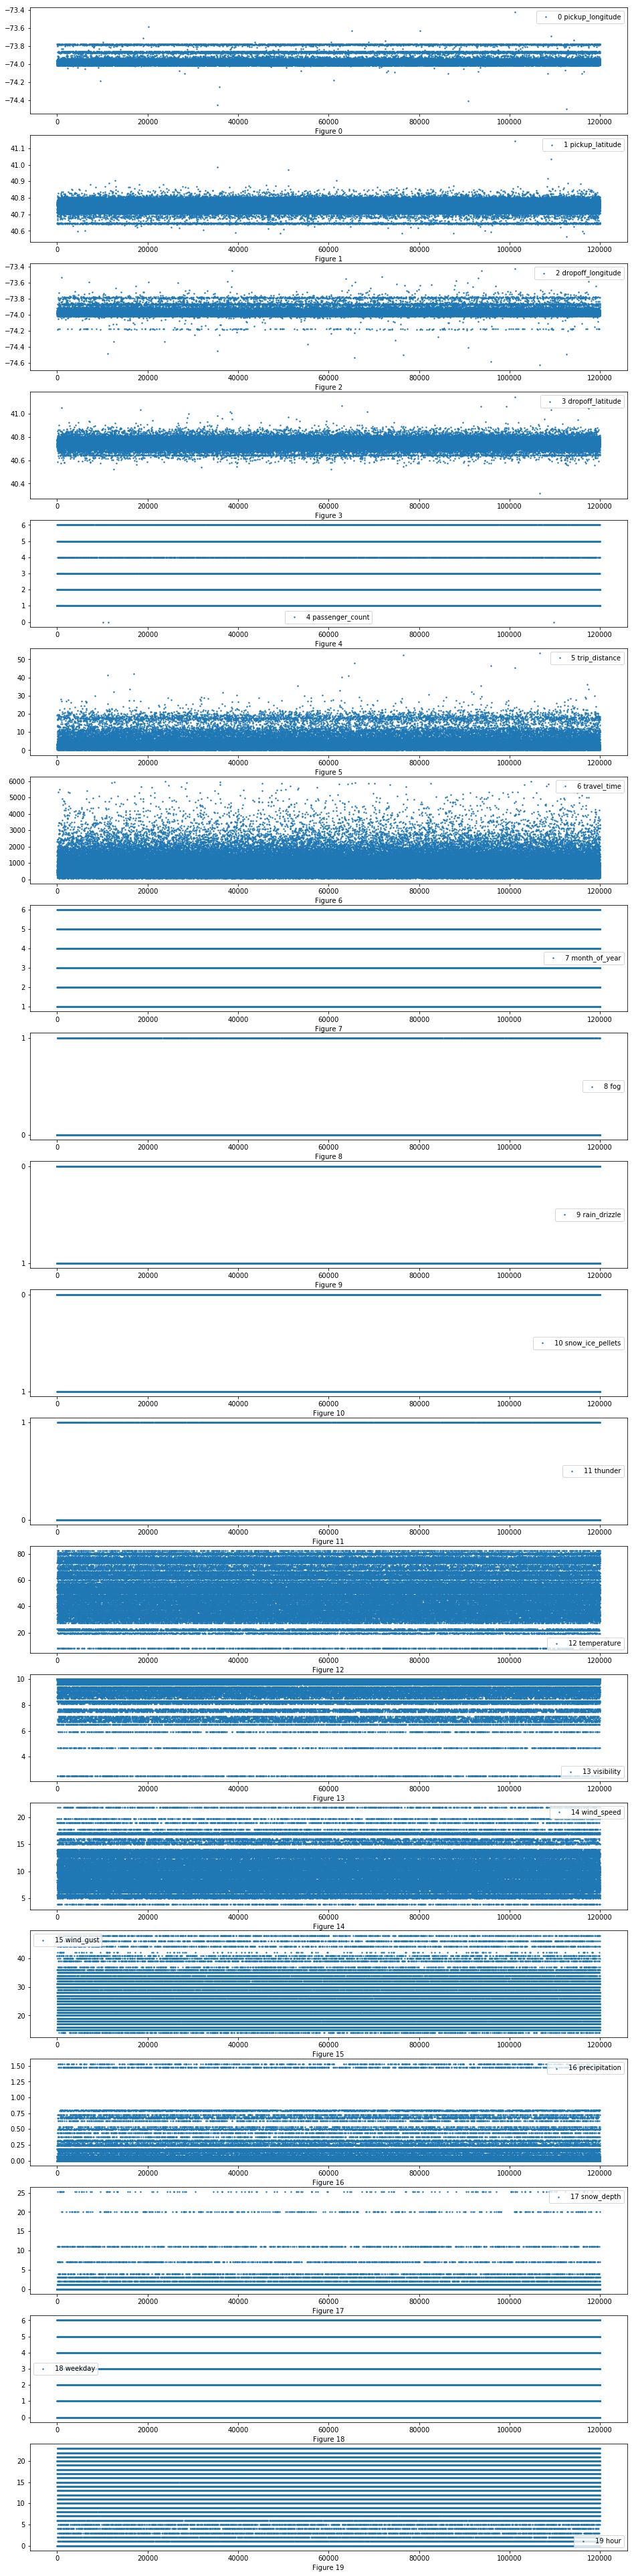

In [8]:
## We select candidate features from original dataframe.

focused_features = df.columns.values.tolist()

## Number of features
rows = len(focused_features)

# Visualize each feature to analyse the abnormal values

plt.figure(figsize=(16,rows*3.5))
for idx, feature in enumerate(focused_features):
    plt.subplot(rows,1,idx+1)
    plt.scatter(range(len(df)), df[feature], s=2, label=str(idx)+' '+feature)
    plt.xlabel('Figure '+ str(idx))
    plt.legend()


### Filter noise for each feature according to the observations above
Based on the above plots, we can determine the normal range of each feature. For example in figure 0 of feature `pickup_longitude`, the value 0 of `pickup_longitude` is impossible for the coordinates in New York. Thus we give the the minimum and maximum values of `pickup_longitude` as -100 and -50, respectively. i.e., `filters[0] = (-100, -50)`

In [199]:
filters = {}

## filters[i] =(min, max) : remove ith feature with min/max filter, 
                            ##values below are dertermined by figures above
filters[0] = (-74.17, -73.8)
filters[1] = (40.62, 40.91)
filters[2] = (-74.68, -72.1)
filters[3] = (40.21,41.75)
filters[4] = (1, 9)
filters[5] = (0.1, 40)
filters[6] = (60, 5400)

## Initialize boolean filter
bools = df['pickup_longitude'] > -1000

## Join filters of all features
for k, v in filters.items():
    bools = bools & (df[focused_features[k]] >= v[0]) & (df[focused_features[k]]<=v[1])
    
## Select qualified values
df = df[bools]

print("After filter with abnormal features: ", len(df))

After filter with abnormal features:  2930979


# Feature Engineering

### [Information leakage] With the raw features, we can compute some useful high-level features. 
Here we extend three features, `L2_distance_km`, `from_center_distance`, `dropoff2center_distance`:
* `L2_distance_km` is the direct Euclidean distance from the pickup location to the dropoff location of each trip. This is because the travel time of the trip is strongly connected to the `L2_distance`.
* `pickup2center_distance` is the distance from the pickup location to the city center. From our oberservation, if the pickup location is near to the city center, we are likely to spend more time on taxi.
* `dropoff2center_distance` is the distance from the dropoff location to the city center.

In [200]:
A = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 
                    df['pickup_longitude'].tolist(), df['pickup_latitude'].tolist())
df['pickup_coordinate_x'] = list(map(lambda x:x/1000,A[0]))
df['pickup_coordinate_y'] = list(map(lambda x:x/1000,A[1]))

B = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 
                    df['dropoff_longitude'].tolist(), df['dropoff_latitude'].tolist())
df['dropoff_coordinate_x'] = list(map(lambda x:x/1000,B[0]))
df['dropoff_coordinate_y'] = list(map(lambda x:x/1000,B[1]))

df['L2_distance_km'] = ((df['pickup_coordinate_x'] - df['dropoff_coordinate_x'])**2 + 
                     (df['pickup_coordinate_y'] - df['dropoff_coordinate_y'])**2)**0.5
#df['L2_distance_km'] = abs(df['pickup_coordinate_x'] - df['dropoff_coordinate_x'])+ abs(df['pickup_coordinate_y'] - df['dropoff_coordinate_y'])
#df['true_distance'] = df['trip_distance']*1.6
df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,travel_time,month_of_year,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth,weekday,hour,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km
0,-73.987106,40.729305,-73.988228,40.723179,5,0.79,809,3,0,0,0,0,34.8,10.0,9.4,19.0,0.04,1.2,5,0,-8236.207001,4972.495871,-8236.331848,4971.595955,0.908535
1,-73.988998,40.738209,-73.960381,40.774647,1,3.72,959,2,0,0,0,0,45.5,10.0,5.0,17.1,0.00,1.2,1,23,-8236.417628,4973.803866,-8233.231902,4979.158721,6.230836
2,-74.003967,40.742897,-73.935898,40.755882,2,5.60,1153,3,0,1,0,0,61.2,9.8,9.7,28.0,0.04,0.0,4,4,-8238.083955,4974.492680,-8230.506497,4976.400762,7.814003
3,-73.975220,40.748051,-73.972908,40.746620,5,1.20,530,1,0,0,1,0,29.0,9.2,15.0,31.1,0.05,0.0,0,20,-8234.883791,4975.249926,-8234.626453,4975.039730,0.332273
4,-73.962250,40.779129,-73.937210,40.855160,3,6.88,2127,1,0,1,0,0,32.9,10.0,9.0,28.0,0.00,0.0,1,17,-8233.439981,4979.817630,-8230.652577,4991.001178,11.525683


In [201]:
## Coordinates of city center
pickup_center_x = df['pickup_coordinate_x'].mean()
pickup_center_y = df['pickup_coordinate_y'].mean()

dropoff_center_x = df['dropoff_coordinate_x'].mean()
dropoff_center_y = df['dropoff_coordinate_y'].mean()

center_x = (pickup_center_x + dropoff_center_x) / 2
center_y = (pickup_center_y + dropoff_center_y) / 2

#L2_distance
df['pickup2center_distance'] = ((df['pickup_coordinate_x'] - center_x)**2 + 
                               (df['pickup_coordinate_y'] - center_y)**2)**0.5
df['dropoff2center_distance'] = ((df['dropoff_coordinate_x'] - center_x)**2 + 
                                (df['dropoff_coordinate_y'] - center_y)**2)**0.5

#L1_distance
#df['pickup2center_distance'] = abs(df['pickup_coordinate_x'] - center_x) + abs(df['pickup_coordinate_y'] - center_y)
#df['dropoff2center_distance'] = abs(df['dropoff_coordinate_x'] - center_x)+ abs(df['dropoff_coordinate_y'] - center_y)

df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,travel_time,month_of_year,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth,weekday,hour,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km,pickup2center_distance,dropoff2center_distance
0,-73.987106,40.729305,-73.988228,40.723179,5,0.79,809,3,0,0,0,0,34.8,10.0,9.4,19.0,0.04,1.2,5,0,-8236.207001,4972.495871,-8236.331848,4971.595955,0.908535,3.675916,4.569201
1,-73.988998,40.738209,-73.960381,40.774647,1,3.72,959,2,0,0,0,0,45.5,10.0,5.0,17.1,0.00,1.2,1,23,-8236.417628,4973.803866,-8233.231902,4979.158721,6.230836,2.594356,3.643045
2,-74.003967,40.742897,-73.935898,40.755882,2,5.60,1153,3,0,1,0,0,61.2,9.8,9.7,28.0,0.04,0.0,4,4,-8238.083955,4974.492680,-8230.506497,4976.400762,7.814003,3.439765,4.487347
3,-73.975220,40.748051,-73.972908,40.746620,5,1.20,530,1,0,0,1,0,29.0,9.2,15.0,31.1,0.05,0.0,0,20,-8234.883791,4975.249926,-8234.626453,4975.039730,0.332273,0.713640,0.981211
4,-73.962250,40.779129,-73.937210,40.855160,3,6.88,2127,1,0,1,0,0,32.9,10.0,9.0,28.0,0.00,0.0,1,17,-8233.439981,4979.817630,-8230.652577,4991.001178,11.525683,4.152460,15.650919


### One hot encoding,  Normalization, Remove useless features
Normally, we need to use one hot encoding on categorical feature and use normalization on numerical feature. However, in our experiments, we found that some numerical features can be categorized. For example, `mta_tax` feature only contains 8 types of values (-2.7,-1.0, ..., 0.5). Thus, we use one hot encoding on `mta_tax` feature as (mta_tax_-2.7,mta_tax_-1.0,mta_tax_-0.5,	mta_tax_0.0,	mta_tax_0.05,	mta_tax_0.25,	mta_tax_0.3	mta_tax_0.5).
* We define a threshold `Value_Count_Threshold` to determine each feature to be one hot encoded or be normalized. If the number of value types of a feature is less than `Value_Count_Threshold`, we use one hot encoding. Otherwise, we apply normalization on the feature.

In [202]:
clean_df = pd.DataFrame()

focused_features = df.columns.values.tolist()

Value_Count_Threshold = 24
## Merge all processed features
for idx, feature in enumerate(focused_features):
    
    ## Remove trip_distance feature which is inaccessible in prediction phase
    if feature in ['trip_distance']:
        continue
    ## Keep the target feature unchanged
    if feature == 'travel_time':
        clean_df[feature] = df[feature]
        continue
    ## Count the values of each feature
    value_num = len(df[feature].value_counts())
    print(idx, feature, value_num)
    
    ## Remove useless feature
    if value_num <= 1: continue
        
    if value_num <=Value_Count_Threshold and value_num > 2:
        ## One-Hot encoding on categorical feature
        temp_df = pd.get_dummies(df[feature], prefix=feature)
        clean_df = pd.concat([clean_df, temp_df], axis=1)
        
    else:
        ## Min-Max normalization on numerical feature.
        df[feature] = df[feature].astype(float)
        #clean_df[feature] = (df[feature]- df[feature].min())/(df[feature].max()-df[feature].min())
        clean_df[feature] = df[feature]
print(clean_df.shape)        
clean_df.head()

0 pickup_longitude 22402
1 pickup_latitude 47538
2 dropoff_longitude 36026
3 dropoff_latitude 68837
4 passenger_count 8
7 month_of_year 6
8 fog 2
9 rain_drizzle 2
10 snow_ice_pellets 2
11 thunder 2
12 temperature 136
13 visibility 29
14 wind_speed 87
15 wind_gust 31
16 precipitation 35
17 snow_depth 9
18 weekday 7
19 hour 24
20 pickup_coordinate_x 22402
21 pickup_coordinate_y 47538
22 dropoff_coordinate_x 36026
23 dropoff_coordinate_y 68837
24 L2_distance_km 2923195
25 pickup2center_distance 2667017
26 dropoff2center_distance 2774699
(2930979, 75)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_8,passenger_count_9,travel_time,month_of_year_1,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth_0.0,snow_depth_1.2,snow_depth_2.0,snow_depth_3.1,snow_depth_3.9,snow_depth_7.1,snow_depth_11.0,snow_depth_20.1,snow_depth_25.2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km,pickup2center_distance,dropoff2center_distance
0,-73.987106,40.729305,-73.988228,40.723179,0,0,0,0,1,0,0,0,809,0,0,1,0,0,0,0.0,0.0,0.0,0.0,34.8,10.0,9.4,19.0,0.04,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-8236.207001,4972.495871,-8236.331848,4971.595955,0.908535,3.675916,4.569201
1,-73.988998,40.738209,-73.960381,40.774647,1,0,0,0,0,0,0,0,959,0,1,0,0,0,0,0.0,0.0,0.0,0.0,45.5,10.0,5.0,17.1,0.00,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-8236.417628,4973.803866,-8233.231902,4979.158721,6.230836,2.594356,3.643045
2,-74.003967,40.742897,-73.935898,40.755882,0,1,0,0,0,0,0,0,1153,0,0,1,0,0,0,0.0,1.0,0.0,0.0,61.2,9.8,9.7,28.0,0.04,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-8238.083955,4974.492680,-8230.506497,4976.400762,7.814003,3.439765,4.487347
3,-73.975220,40.748051,-73.972908,40.746620,0,0,0,0,1,0,0,0,530,1,0,0,0,0,0,0.0,0.0,1.0,0.0,29.0,9.2,15.0,31.1,0.05,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-8234.883791,4975.249926,-8234.626453,4975.039730,0.332273,0.713640,0.981211
4,-73.962250,40.779129,-73.937210,40.855160,0,0,1,0,0,0,0,0,2127,1,0,0,0,0,0,0.0,1.0,0.0,0.0,32.9,10.0,9.0,28.0,0.00,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-8233.439981,4979.817630,-8230.652577,4991.001178,11.525683,4.152460,15.650919


#### Get Correlation Matrix

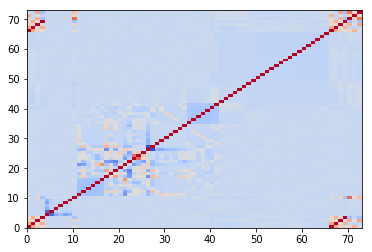

L2_distance_km             0.733218
dropoff2center_distance    0.385894
dropoff_coordinate_x       0.252713
dropoff_longitude          0.252713
dropoff_latitude           0.197164
dropoff_coordinate_y       0.197010
pickup2center_distance     0.196576
pickup_longitude           0.170582
pickup_coordinate_x        0.170582
hour_6                     0.054993
temperature                0.050424
weekday_6                  0.048647
weekday_2                  0.045054
weekday_5                  0.043673
hour_16                    0.041059
weekday_3                  0.041018
hour_7                     0.038819
pickup_latitude            0.037683
pickup_coordinate_y        0.037675
Name: travel_time, dtype: float64

In [110]:
plt.pcolor(clean_df.corr(),cmap='coolwarm') 
plt.show()
clean_df.corr().loc[:,'travel_time'].abs().sort_values(ascending=False)[1:20]

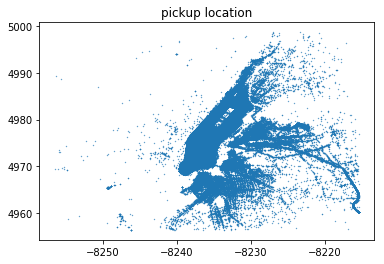

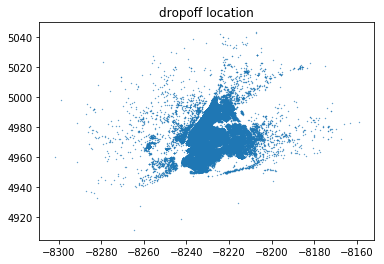

In [203]:
plt.scatter(clean_df['pickup_coordinate_x'], clean_df['pickup_coordinate_y'],s= .1)

plt.title('pickup location')
plt.show()

plt.scatter(clean_df['dropoff_coordinate_x'], clean_df['dropoff_coordinate_y'],s= .1)
plt.title('dropoff location')
plt.show()

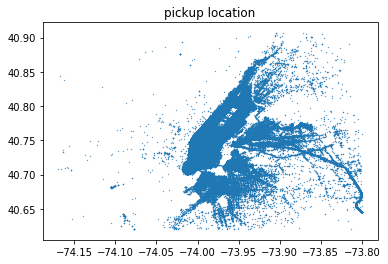

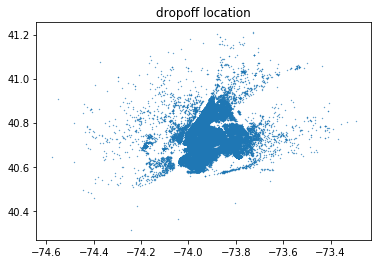

In [204]:
plt.scatter(clean_df['pickup_longitude'], clean_df['pickup_latitude'],s= .1)
plt.title('pickup location')
plt.show()
plt.scatter(clean_df['dropoff_longitude'], clean_df['dropoff_latitude'],s= .1)
plt.title('dropoff location')
plt.show()

## Linear model

In [13]:
clean_df = pd.read_csv('clean_df_2016_10000.csv')
len(clean_df)

117206

In [11]:
y = clean_df['travel_time'] # y is the variable travel time which we should make predictions.
X = clean_df.drop(columns=['travel_time']) # X is matrix of features. In this case, we choose  all features listed in clean_df.

X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X, y, test_size=0.2) # 80% train, 20% test 

### LinearRegression

In [114]:
reg1 = LinearRegression() 

#score_RMSLE = cross_val_score(reg1, X, y, cv=3,
#                              scoring = 'neg_mean_squared_log_error') #3-fold cv
#print(np.mean((-score_RMSLE)**0.5))

score_RMSE = cross_val_score(reg1, X, y, cv=3,
                             scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))

score_R2 = cross_val_score(reg1, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSE =  356.4631020558656
R2 =  0.6250569873004009


This model is not good, but we can take it as a baseline to compare with other model.

In [115]:
X_train = preprocessing.scale(X_train1) 
X_test = preprocessing.scale(X_test1)
y_train = y_train1 - np.mean(y_train1)
y_test = y_test1 - np.mean(y_test1)

Here we apply normlization after train test split, because normalization is to set the average value of the data to be zero and standard variance to be one, which will be convenient to test linear model since all data are set in the same scale and the number of iteration needed is less. We should do this after split because  the data is randomly split, and if we do normlization before, the data will lose characterization of normalization after split.  

In [116]:
reg2 = LinearRegression() 

score_RMSE = cross_val_score(reg2, X_train, y_train, cv=3,
                             scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))

score_R2 = cross_val_score(reg2, X_train, y_train, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSE =  356.75588094100186
R2 =  0.6214825678353453


We found that standardlizing input in this problem doesn't significantly improve the accuracy.

### Lasso

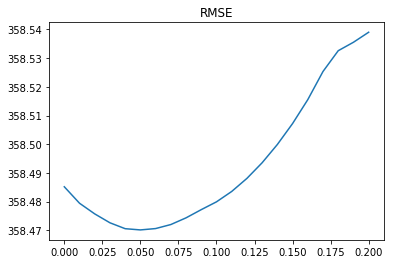

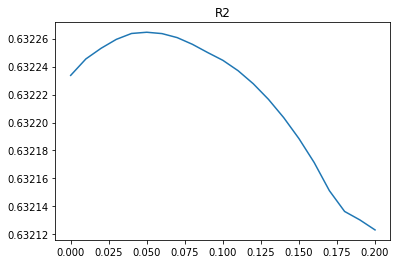

In [146]:
alphas = np.linspace(0,0.2,21) # Find optimal alpha
r2la=[]
RMSE=[]
#RMSLE=[]
for i in range(21):
    reg3 = Lasso(alphas[i]).fit(X_train1, y_train1)
    y_pred = reg3.predict(X_test1)
    r2la.append(reg3.score(X_test1, y_test1))
    RMSE.append((mean_squared_error(y_test1,y_pred))**0.5)
    #RMSLE.append((mean_squared_log_error(y_test1,y_pred))**0.5)

plt.plot(alphas,RMSE) # plot alpha and RMSE scores
plt.title('RMSE')
plt.show()

plt.plot(alphas,r2la) # plot alpha and R2 scores
plt.title('R2')
plt.show()

In [147]:
max(r2la) #max R2

0.6322645752004765

In [148]:
min(RMSE) #min RMSE

358.47014027359086

In [149]:
alphas[np.argmax(r2la)] # argmax RMSE

0.05

### Ridge

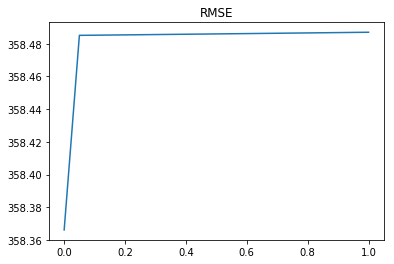

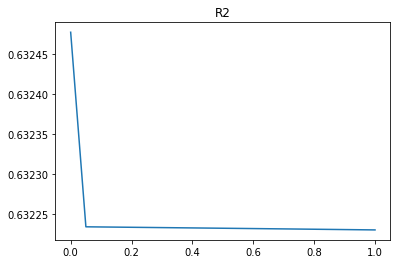

In [150]:
alphas = np.linspace(0,1,21) # Find optimal alpha
r2la=[]
RMSE=[]
#RMSLE=[]
for i in range(21):
    reg4 = Ridge(alphas[i]).fit(X_train1, y_train1)
    y_pred = reg4.predict(X_test1)
    r2la.append(reg4.score(X_test1, y_test1))
    RMSE.append((mean_squared_error(y_test1,y_pred))**0.5)
    #RMSLE.append((mean_squared_log_error(y_test1,y_pred))**0.5)

plt.plot(alphas,RMSE) # plot alpha and RMSE scores
plt.title('RMSE')
plt.show()

plt.plot(alphas,r2la) # plot alpha and R2 scores
plt.title('R2')
plt.show()

In [151]:
max(r2la) #max R2

0.6324778312749352

In [152]:
min(RMSE) #min RMSE

358.36618371126247

In [153]:
alphas[np.argmax(r2la)] # argmax RMSE

0.0

Ridge nodel allows cofficients to decay smoothly because its level sets are circles. It distributes the errors evenly among the remaining features. So the total error of ridge model is smaller than Lasso model. Also, this model set the sum of cofficients to be zero to decreases error. 

In this section, we have a overall view of linear model selection. We can see that linear regression has a lowest score, while Lasso and Ridge have approximate same score while Lasso model has smaller mean square error. So Lasso is better in linear models. Most importantly, the linear models don't have a ideal fit for the data, because the data has very large size and many features, which causes very big variance and complicated trends. We assume other models have better proformance.  

## Other Model

#### MLPRegressor

In [154]:
reg5 = MLPRegressor()
score_RMSLE = cross_val_score(reg5, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg5, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg5, X_train, y_train, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSE =  352.6614980107975
R2 =  0.692268719966298


#### DecisionTree

In [156]:
reg6 = DecisionTreeRegressor()
score_RMSLE = cross_val_score(reg6, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg6, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg6, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSLE =  0.5609129414190946
RMSE =  470.3861992904527
R2 =  0.32917055716063287


In [190]:
parameters = {'max_depth':(1,2,4,6,8,10)}

G = GridSearchCV(reg7, parameters, cv=3)
G.fit(X, y)

G.best_params_,G.best_score_

({'max_depth': 10}, 0.6344073455778602)

#### RandomForest

In [157]:
reg7 = RandomForestRegressor()
score_RMSLE = cross_val_score(reg7, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg7, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg7, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSLE =  0.427141949776181
RMSE =  348.7361226103779
R2 =  0.6390941387236694


In [191]:
parameters = {'n_estimators':(10,20,30,50,100,200)}

G = GridSearchCV(reg7, parameters, cv=3)
G.fit(X, y)

G.best_params_,G.best_score_

({'n_estimators': 200}, 0.6734587892249793)

Feature ranking:
1. feature 17 (0.553994)
2. feature 19 (0.055122)
3. feature 0 (0.042163)
4. feature 2 (0.038692)
5. feature 3 (0.031901)
6. feature 16 (0.031790)
7. feature 13 (0.027862)
8. feature 8 (0.027625)
9. feature 15 (0.027579)
10. feature 10 (0.023675)
11. feature 14 (0.022607)
12. feature 18 (0.022146)
13. feature 11 (0.021813)
14. feature 1 (0.021686)
15. feature 12 (0.016325)
16. feature 9 (0.015409)
17. feature 5 (0.010776)
18. feature 6 (0.004609)
19. feature 7 (0.002827)
20. feature 4 (0.001398)


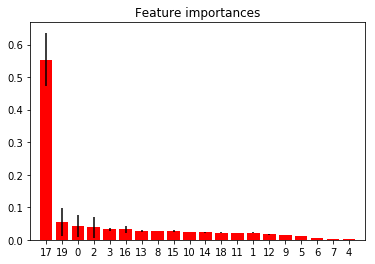

L2_distance_km dropoff2center_distance


In [31]:
from sklearn.datasets import make_regression
from sklearn.ensemble import ExtraTreesRegressor
'''
# Build a classification task using 3 informative features
X, y = make_regression(n_samples=1000,
                           n_features=10,
                           n_informative=5,
                           random_state=0,
                           shuffle=False)
'''
# Build a forest and compute the feature importances
forest = ExtraTreesRegressor(n_estimators=10,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

print(A[17],A[19])

#### GradientBoosting

In [158]:
reg8 = GradientBoostingRegressor()
score_RMSLE = cross_val_score(reg8, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg8, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg8, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSLE =  0.4129591886776434
RMSE =  337.6850863871589
R2 =  0.6635351700857809


In [189]:
parameters = {'n_estimators':(10,20,30,50,100,200,300),'learning_rate':(0.1,0.01,0.001)}

G = GridSearchCV(reg8, parameters, cv=3)
G.fit(X, y)

G.best_params_, G.best_score_

({'learning_rate': 0.1, 'n_estimators': 200}, 0.6858204150933221)

#### AdaBoost

In [159]:
reg9 = AdaBoostRegressor()
score_RMSLE = cross_val_score(reg9, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg9, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg9, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

RMSLE =  0.8327585285245404
RMSE =  598.2848561201939
R2 =  -0.2919614903480256


In [192]:
parameters = {'n_estimators':(10,20,30,50,100,200),'learning_rate':(0.1,0.01,0.001)}

G = GridSearchCV(reg9, parameters, cv=3)
G.fit(X, y)

G.best_params_, G.best_score_

({'learning_rate': 0.01, 'n_estimators': 100}, 0.5694659720870424)

#### CatBoost

In [160]:
reg10 = CatBoostRegressor(verbose = 1000)
score_RMSLE = cross_val_score(reg10, X, y, cv=3,scoring = 'neg_mean_squared_log_error') #3-fold cv
print('RMSLE = ',np.mean((-score_RMSLE)**0.5))
score_RMSE = cross_val_score(reg10, X, y, cv=3,scoring = 'neg_mean_squared_error') #3-fold cv
print('RMSE = ',np.mean((-score_RMSE)**0.5))
score_R2 = cross_val_score(reg10, X, y, cv=3,scoring = 'r2') #3-fold cv
print('R2 = ',np.mean(score_R2))

0:	learn: 972.8586959	total: 73.6ms	remaining: 1m 13s
999:	learn: 295.1809285	total: 11.7s	remaining: 0us
0:	learn: 969.1024464	total: 18.1ms	remaining: 18.1s
999:	learn: 293.9831135	total: 11.3s	remaining: 0us
0:	learn: 962.8333171	total: 22.6ms	remaining: 22.6s
999:	learn: 289.7268591	total: 11.7s	remaining: 0us
RMSLE =  0.391070795148276
0:	learn: 972.8586959	total: 106ms	remaining: 1m 46s
999:	learn: 295.1809285	total: 11.9s	remaining: 0us
0:	learn: 969.1024464	total: 18.6ms	remaining: 18.6s
999:	learn: 293.9831135	total: 10.7s	remaining: 0us
0:	learn: 962.8333171	total: 21.3ms	remaining: 21.3s
999:	learn: 289.7268591	total: 10.4s	remaining: 0us
RMSE =  314.09708265009635
0:	learn: 972.8586959	total: 17.9ms	remaining: 17.9s
999:	learn: 295.1809285	total: 10.7s	remaining: 0us
0:	learn: 969.1024464	total: 18ms	remaining: 18s
999:	learn: 293.9831135	total: 10.5s	remaining: 0us
0:	learn: 962.8333171	total: 17.8ms	remaining: 17.8s
999:	learn: 289.7268591	total: 10.4s	remaining: 0us
R2 =

#### Compare different model

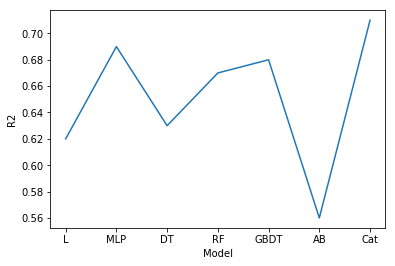

In [217]:
Model = ['L','MLP','DT','RF','GBDT','AB','Cat']
Result = [0.62,0.69,0.63,0.67,0.68,0.56,0.71]
plt.plot(Model,Result)
plt.xlabel('Model')
plt.ylabel('R2')
plt.show()

Our best result is from catboost regressor.

# Start dealing with test data

In [225]:
Test_data = pd.read_csv('APM4990_final_test_data_filtered.csv')
Test_data.head()

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2


In [226]:
len(Test_data)

694047

#### Get the range of test data

In [162]:
for i in Test_data.columns.values.tolist():
    print(min(Test_data[i]),max(Test_data[i]))

2015-01-01 00:00:46+00:00 2015-12-31 23:59:51+00:00
40.620277404785156 40.90388107299805
-74.16976928710938 -73.7921371459961
40.21099090576172 41.74851608276367
-74.67538452148438 -72.09541320800781
0 9


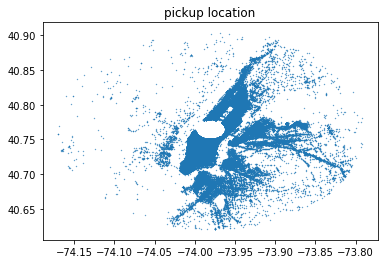

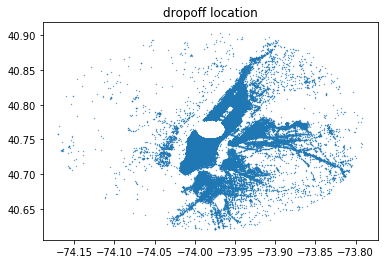

In [163]:
plt.scatter(Test_data['pickup_longitude'], Test_data['pickup_latitude'],s= .1)
plt.title('pickup location')
plt.show()
plt.scatter(Test_data['pickup_longitude'], Test_data['pickup_latitude'],s= .1)
plt.title('dropoff location')
plt.show()

#### Load weather data

In [164]:
query2 = (
    """
     select concat(year,'-',mo,'-',da) as date_of_year,\
     fog,rain_drizzle,snow_ice_pellets,thunder,\
     temp as temperature, visib as visibility, \
     IF (wdsp="999.9", 0, CAST(wdsp AS Float64)) as wind_speed,\
     gust as wind_gust, prcp as precipitation, IF (sndp=999.9, 0, sndp) as snow_depth
     from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725030'
    """
)
df2=pd.io.gbq.read_gbq(query2,dialect='standard')
df2.head(1)

,date_of_year,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth
0,2015-12-30,0,0,0,0,41.8,7.5,4.8,999.9,0.13,0.0


#### test data join weather data

In [165]:
Test_data['date_of_year'] = Test_data.pickup_datetime.apply(lambda t: t[0:10])
test = Test_data.merge(df2, on = 'date_of_year',how='left')
test.head(2)

,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,date_of_year,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5,2015-06-18,0,1,0,0,66.8,10.0,7.5,14.0,0.0,0.0
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1,2015-11-08,0,0,0,0,53.5,10.0,9.9,24.1,0.0,0.0


#### Extend 'weekday' , 'month_of_year' and 'hour'

In [166]:
test['pickup_datetime'] = test['pickup_datetime'].apply(lambda t: t[0:13])
test['pickup_datetime'] = test['pickup_datetime'].apply(lambda t: 
                                                        time.strptime(t,'%Y-%m-%d %H'))

test['weekday'] = test['pickup_datetime'].apply(lambda t: t.tm_wday)
test['month_of_year'] = test['pickup_datetime'].apply(lambda t: t.tm_mon)
test['hour'] = test['pickup_datetime'].apply(lambda t: t.tm_hour)

Drop = ['pickup_datetime','date_of_year']
test.drop(Drop,axis='columns',inplace=True)
test.head(2)

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth,weekday,month_of_year,hour
0,40.702740,-74.011650,40.773361,-73.990311,5,0,1,0,0,66.8,10.0,7.5,14.0,0.0,0.0,3,6,21
1,40.733608,-74.003098,40.836803,-73.941643,1,0,0,0,0,53.5,10.0,9.9,24.1,0.0,0.0,6,11,2


#### Calculate the coordinate and distance

In [167]:
A = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 
                    test['pickup_longitude'].tolist(), test['pickup_latitude'].tolist())
test['pickup_coordinate_x'] = list(map(lambda x:x/1000,A[0]))
test['pickup_coordinate_y'] = list(map(lambda x:x/1000,A[1]))

B = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), 
                    test['dropoff_longitude'].tolist(), test['dropoff_latitude'].tolist())
test['dropoff_coordinate_x'] = list(map(lambda x:x/1000,B[0]))
test['dropoff_coordinate_y'] = list(map(lambda x:x/1000,B[1]))

test['L2_distance_km'] = ((test['pickup_coordinate_x'] - test['dropoff_coordinate_x'])**2 + 
                     (test['pickup_coordinate_y'] - test['dropoff_coordinate_y'])**2)**0.5
#test['L2_distance_km'] = abs(test['pickup_coordinate_x'] - test['dropoff_coordinate_x'])+ abs(test['pickup_coordinate_y'] - test['dropoff_coordinate_y'])
#test['true_distance'] = test['trip_distance']*1.6


test['pickup2center_distance'] = ((test['pickup_coordinate_x'] - center_x)**2 + 
                               (test['pickup_coordinate_y'] - center_y)**2)**0.5
test['dropoff2center_distance'] = ((test['dropoff_coordinate_x'] - center_x)**2 + 
                                (test['dropoff_coordinate_y'] - center_y)**2)**0.5
test.head(2)

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth,weekday,month_of_year,hour,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km,pickup2center_distance,dropoff2center_distance
0,40.702740,-74.011650,40.773361,-73.990311,5,0,1,0,0,66.8,10.0,7.5,14.0,0.0,0.0,3,6,21,-8238.939200,4968.594220,-8236.563707,4978.969749,10.643992,8.397315,3.378922
1,40.733608,-74.003098,40.836803,-73.941643,1,0,0,0,0,53.5,10.0,9.9,24.1,0.0,0.0,6,11,2,-8237.987135,4973.127991,-8231.146021,4988.299927,16.642971,4.162865,12.886940


#### One Hot Encoding

In [168]:
test_new = pd.DataFrame()

focused_features = test.columns.values.tolist()

Value_Count_Threshold = 24
## Merge all processed features
for idx, feature in enumerate(focused_features):

    ## Count the values of each feature
    value_num = len(test[feature].value_counts())
    #print(idx, feature, value_num)
    
    ## Remove useless feature
    if value_num <= 1: continue
        
    if value_num <=Value_Count_Threshold and value_num > 2:
        ## One-Hot encoding on categorical feature
        temp_test = pd.get_dummies(test[feature], prefix=feature)
        test_new = pd.concat([test_new, temp_test], axis=1)
        
    else:
        ## Min-Max normalization on numerical feature.
        test[feature] = test[feature].astype(float)
        #test_new[feature] = (test[feature]- test[feature].min())/(test[feature].max()-test[feature].min())
        test_new[feature] = test[feature]
#print(test_new.shape)        
test_new.head(1)

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count_0,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth_0.0,snow_depth_1.2,snow_depth_2.0,snow_depth_3.1,snow_depth_3.9,snow_depth_5.1,snow_depth_5.9,snow_depth_7.1,snow_depth_7.9,snow_depth_9.1,snow_depth_9.8,snow_depth_11.0,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,month_of_year_1,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km,pickup2center_distance,dropoff2center_distance
0,40.70274,-74.01165,40.773361,-73.990311,0,0,0,0,0,1,0,0,0,0,0.0,1.0,0.0,0.0,66.8,10.0,7.5,14.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-8238.9392,4968.59422,-8236.563707,4978.969749,10.643992,8.397315,3.378922


#### change the order of feature of test data to be the same as training data set

In [169]:
Features_Train = X.columns.values.tolist()
Features_Test = test_new.columns.values.tolist()
test_final = pd.DataFrame()
for i in Features_Train:
    if i in Features_Test:
        test_final[i] = test_new[i]
    else:
        test_final[i] = 0 
test_final.head(1)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,month_of_year_1,month_of_year_2,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,fog,rain_drizzle,snow_ice_pellets,thunder,temperature,visibility,wind_speed,wind_gust,precipitation,snow_depth_0.0,snow_depth_1.2,snow_depth_2.0,snow_depth_3.1,snow_depth_3.9,snow_depth_7.1,snow_depth_11.0,snow_depth_20.1,snow_depth_25.2,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickup_coordinate_x,pickup_coordinate_y,dropoff_coordinate_x,dropoff_coordinate_y,L2_distance_km,pickup2center_distance,dropoff2center_distance
0,-74.01165,40.70274,-73.990311,40.773361,0,0,0,0,1,0,0,0,0,0,0,1,0.0,1.0,0.0,0.0,66.8,10.0,7.5,14.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-8238.9392,4968.59422,-8236.563707,4978.969749,10.643992,8.397315,3.378922


#### Choose the best model (CatBoost) to make prediction

In [206]:
P = CatBoostRegressor(verbose = 500)
P.fit(X,y)
Pred = P.predict(test_final)

0:	learn: 967.9064382	total: 619ms	remaining: 10m 17s
500:	learn: 307.8524950	total: 2m 35s	remaining: 2m 34s
999:	learn: 291.7195610	total: 5m 11s	remaining: 0us


In [209]:
np.mean(Pred)

1038.9522379194882

In [220]:
for i in range(len(Pred)):
    if Pred[i] <0:
        Pred[i] = 0        

In [227]:
np.savetxt("prediction_onlyonecolumn.csv", Pred,fmt='%d',delimiter=',',header='predictions', comments='')